# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References: 

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [2]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST 
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 62746035.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104607680.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38820826.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 27730027.32it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [4]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()
        
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()
        
        
        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [5]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()
    
    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())
    
    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)
            
        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)
        
    return train_loss_lst, val_loss_lst

In [6]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

In [6]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████████████| 168/168 [00:01<00:00, 107.89it/s, loss=0.149]


Epoch [1/30] Train Loss: 0.14933186718484476


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 154.46it/s, loss=0.0629]


Epoch [1/30] Validation Loss: 0.06286703370925453


Training: 100%|█████████████████| 168/168 [00:01<00:00, 137.21it/s, loss=0.0693]


Epoch [2/30] Train Loss: 0.0692892816178279


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 146.92it/s, loss=0.0611]


Epoch [2/30] Validation Loss: 0.061095939004897244


Training: 100%|█████████████████| 168/168 [00:01<00:00, 132.72it/s, loss=0.0573]


Epoch [3/30] Train Loss: 0.05725510023157334


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 156.70it/s, loss=0.0551]


Epoch [3/30] Validation Loss: 0.05512118190462287


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.25it/s, loss=0.0455]


Epoch [4/30] Train Loss: 0.04553046500604112


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 158.39it/s, loss=0.0428]


Epoch [4/30] Validation Loss: 0.04281151670632729


Training: 100%|█████████████████| 168/168 [00:01<00:00, 137.87it/s, loss=0.0443]


Epoch [5/30] Train Loss: 0.044287869350574466


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 157.15it/s, loss=0.0458]


Epoch [5/30] Validation Loss: 0.045809944667982765


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.49it/s, loss=0.0389]


Epoch [6/30] Train Loss: 0.03889225736479386


Validation: 100%|██████████████████| 72/72 [00:00<00:00, 149.50it/s, loss=0.055]


Epoch [6/30] Validation Loss: 0.05495715997272378


Training: 100%|█████████████████| 168/168 [00:01<00:00, 139.79it/s, loss=0.0387]


Epoch [7/30] Train Loss: 0.03872360478756794


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 157.07it/s, loss=0.0342]


Epoch [7/30] Validation Loss: 0.03422206855935252


Training: 100%|█████████████████| 168/168 [00:01<00:00, 137.86it/s, loss=0.0327]


Epoch [8/30] Train Loss: 0.0327019439781517


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 155.21it/s, loss=0.0373]


Epoch [8/30] Validation Loss: 0.03734635477141839


Training: 100%|█████████████████| 168/168 [00:01<00:00, 135.68it/s, loss=0.0356]


Epoch [9/30] Train Loss: 0.03560796978507867


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 155.37it/s, loss=0.0409]


Epoch [9/30] Validation Loss: 0.04089845901398803


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.81it/s, loss=0.0343]


Epoch [10/30] Train Loss: 0.034252971674591425


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 153.90it/s, loss=0.0388]


Epoch [10/30] Validation Loss: 0.03882684804496724


Training: 100%|█████████████████| 168/168 [00:01<00:00, 138.73it/s, loss=0.0331]


Epoch [11/30] Train Loss: 0.03305167252082832


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 155.00it/s, loss=0.0454]


Epoch [11/30] Validation Loss: 0.04540025969092514


Training: 100%|█████████████████| 168/168 [00:01<00:00, 135.51it/s, loss=0.0301]


Epoch [12/30] Train Loss: 0.03012808299432176


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 157.83it/s, loss=0.0372]


Epoch [12/30] Validation Loss: 0.03720840583648371


Training: 100%|█████████████████| 168/168 [00:01<00:00, 138.92it/s, loss=0.0304]


Epoch [13/30] Train Loss: 0.030433479537567195


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 160.13it/s, loss=0.0438]


Epoch [13/30] Validation Loss: 0.04383453529771941


Training: 100%|█████████████████| 168/168 [00:01<00:00, 137.21it/s, loss=0.0274]


Epoch [14/30] Train Loss: 0.027426294209969154


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 156.31it/s, loss=0.0463]


Epoch [14/30] Validation Loss: 0.04630647162351428


Training: 100%|█████████████████| 168/168 [00:01<00:00, 137.53it/s, loss=0.0277]


Epoch [15/30] Train Loss: 0.02771474479024099


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 156.48it/s, loss=0.0509]


Epoch [15/30] Validation Loss: 0.050858664745141544


Training: 100%|█████████████████| 168/168 [00:01<00:00, 138.89it/s, loss=0.0287]


Epoch [16/30] Train Loss: 0.028659748730292665


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 155.05it/s, loss=0.0429]


Epoch [16/30] Validation Loss: 0.042862602280567645


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.78it/s, loss=0.0193]


Epoch [17/30] Train Loss: 0.019339816354355815


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 157.88it/s, loss=0.0397]


Epoch [17/30] Validation Loss: 0.03971146041840257


Training: 100%|█████████████████| 168/168 [00:01<00:00, 126.61it/s, loss=0.0223]


Epoch [18/30] Train Loss: 0.022309415107364266


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 138.76it/s, loss=0.0477]


Epoch [18/30] Validation Loss: 0.04767566159734492


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.03it/s, loss=0.0275]


Epoch [19/30] Train Loss: 0.027466415036109366


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 153.10it/s, loss=0.0452]


Epoch [19/30] Validation Loss: 0.04520998123300362


Training: 100%|█████████████████| 168/168 [00:01<00:00, 139.36it/s, loss=0.0307]


Epoch [20/30] Train Loss: 0.030713143446129316


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 155.30it/s, loss=0.0567]


Epoch [20/30] Validation Loss: 0.05667133948574903


Training: 100%|█████████████████| 168/168 [00:01<00:00, 139.54it/s, loss=0.0221]


Epoch [21/30] Train Loss: 0.022059973280799266


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 157.38it/s, loss=0.0397]


Epoch [21/30] Validation Loss: 0.03969193083119333


Training: 100%|█████████████████| 168/168 [00:01<00:00, 140.36it/s, loss=0.0256]


Epoch [22/30] Train Loss: 0.025620731208445727


Validation: 100%|██████████████████| 72/72 [00:00<00:00, 154.31it/s, loss=0.046]


Epoch [22/30] Validation Loss: 0.04604798716112176


Training: 100%|██████████████████| 168/168 [00:01<00:00, 138.89it/s, loss=0.022]


Epoch [23/30] Train Loss: 0.02198525760121854


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 157.45it/s, loss=0.0431]


Epoch [23/30] Validation Loss: 0.043142043826012215


Training: 100%|█████████████████| 168/168 [00:01<00:00, 135.50it/s, loss=0.0189]


Epoch [24/30] Train Loss: 0.01888838153575177


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 158.04it/s, loss=0.0401]


Epoch [24/30] Validation Loss: 0.04013342797401896


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.67it/s, loss=0.0206]


Epoch [25/30] Train Loss: 0.02062189068133843


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 154.72it/s, loss=0.0482]


Epoch [25/30] Validation Loss: 0.048244417440501924


Training: 100%|█████████████████| 168/168 [00:01<00:00, 139.62it/s, loss=0.0278]


Epoch [26/30] Train Loss: 0.027788216903510538


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 156.75it/s, loss=0.0382]


Epoch [26/30] Validation Loss: 0.03815588849992461


Training: 100%|█████████████████| 168/168 [00:01<00:00, 134.41it/s, loss=0.0193]


Epoch [27/30] Train Loss: 0.019341656480481192


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 158.24it/s, loss=0.0449]


Epoch [27/30] Validation Loss: 0.044872063286245774


Training: 100%|█████████████████| 168/168 [00:01<00:00, 136.80it/s, loss=0.0219]


Epoch [28/30] Train Loss: 0.021920076200937427


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 139.16it/s, loss=0.0417]


Epoch [28/30] Validation Loss: 0.04169640849770278


Training: 100%|██████████████████| 168/168 [00:01<00:00, 135.23it/s, loss=0.023]


Epoch [29/30] Train Loss: 0.022968304885309754


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 156.25it/s, loss=0.0505]


Epoch [29/30] Validation Loss: 0.050509686620200805


Training: 100%|██████████████████| 168/168 [00:01<00:00, 139.65it/s, loss=0.021]


Epoch [30/30] Train Loss: 0.02103841142414218


Validation: 100%|█████████████████| 72/72 [00:00<00:00, 158.91it/s, loss=0.0429]

Epoch [30/30] Validation Loss: 0.042913090224020484


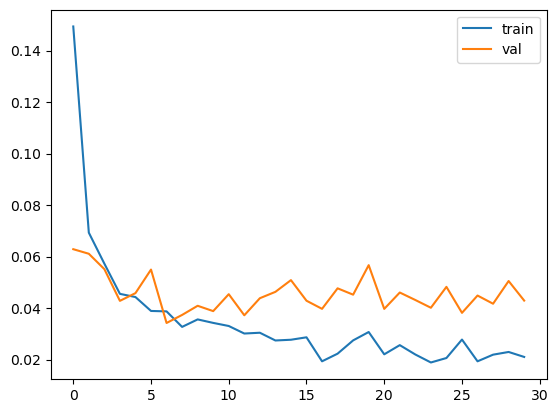

In [7]:
plot_losses(train_loss_lst,val_loss_lst)

In [8]:
# save the model
path1= ...
torch.save(net,path1)

path2=...
# Save the state dictionary
torch.save(net.state_dict(), path2)


# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/ 


In [66]:
path1= "/Users/halvardbariller/Documents/GITHUB/practical-deep-learning/3_TransferLearning/models/model_pretrained_subset1.pth"
path2="/Users/halvardbariller/Documents/GITHUB/practical-deep-learning/3_TransferLearning/models/model_pretrained_subset1_state_dict.pth"

In [67]:
net=torch.load(path1, map_location=device).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [68]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [69]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')


Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [70]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0
    
    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1
                    
                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')
        
    return accuracy

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:00<00:00, 147.52it/s]

Accuracy: 0.994
Wrong counts for the digit 0: 3
Wrong counts for the digit 1: 4
Wrong counts for the digit 2: 10
Wrong counts for the digit 3: 4
Wrong counts for the digit 4: 11


0.994

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [71]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9
# keep images of desired labels
class_names_subset2 = [5, 6, 7, 8, 9]

# create a mask to filter indices for each label
train_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)


# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [72]:
test(test_loader_subset2, "Testing_subset2", net, {i: 0 for i in range(5, 10)})

Testing_subset2: 100%|██████████| 38/38 [00:00<00:00, 142.29it/s]

Accuracy: 0.394
Wrong counts for the digit 5: 741
Wrong counts for the digit 6: 935
Wrong counts for the digit 7: 709
Wrong counts for the digit 8: 403
Wrong counts for the digit 9: 160


0.394

# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [73]:
train_loss_lst_2, val_loss_lst_2 = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)

Training: 100%|██████████| 161/161 [00:02<00:00, 55.94it/s, loss=5.98]


Epoch [1/10] Train Loss: 5.978000032235377


Validation: 100%|██████████| 69/69 [00:00<00:00, 139.10it/s, loss=4.15]


Epoch [1/10] Validation Loss: 4.147287475890008


Training: 100%|██████████| 161/161 [00:02<00:00, 55.74it/s, loss=3.87]


Epoch [2/10] Train Loss: 3.874290293047887


Validation: 100%|██████████| 69/69 [00:00<00:00, 144.20it/s, loss=2.4] 


Epoch [2/10] Validation Loss: 2.3989553814348965


Training: 100%|██████████| 161/161 [00:02<00:00, 55.31it/s, loss=2.39]


Epoch [3/10] Train Loss: 2.385222463874343


Validation: 100%|██████████| 69/69 [00:00<00:00, 135.00it/s, loss=1.36]


Epoch [3/10] Validation Loss: 1.3569113949070806


Training: 100%|██████████| 161/161 [00:02<00:00, 54.61it/s, loss=1.46]


Epoch [4/10] Train Loss: 1.4636380890881793


Validation: 100%|██████████| 69/69 [00:00<00:00, 133.30it/s, loss=0.801]


Epoch [4/10] Validation Loss: 0.8010480576667233


Training: 100%|██████████| 161/161 [00:02<00:00, 54.20it/s, loss=0.974]


Epoch [5/10] Train Loss: 0.9743393515207752


Validation: 100%|██████████| 69/69 [00:00<00:00, 141.61it/s, loss=0.564]


Epoch [5/10] Validation Loss: 0.564095622819403


Training: 100%|██████████| 161/161 [00:02<00:00, 55.16it/s, loss=0.738]


Epoch [6/10] Train Loss: 0.7377387749852601


Validation: 100%|██████████| 69/69 [00:00<00:00, 133.06it/s, loss=0.446]


Epoch [6/10] Validation Loss: 0.4464248954385951


Training: 100%|██████████| 161/161 [00:02<00:00, 55.59it/s, loss=0.626]


Epoch [7/10] Train Loss: 0.6260417349960493


Validation: 100%|██████████| 69/69 [00:00<00:00, 133.98it/s, loss=0.375]


Epoch [7/10] Validation Loss: 0.374673188596532


Training: 100%|██████████| 161/161 [00:02<00:00, 55.69it/s, loss=0.528]


Epoch [8/10] Train Loss: 0.5275474757141208


Validation: 100%|██████████| 69/69 [00:00<00:00, 133.96it/s, loss=0.321]


Epoch [8/10] Validation Loss: 0.32118374368418817


Training: 100%|██████████| 161/161 [00:02<00:00, 55.29it/s, loss=0.472]


Epoch [9/10] Train Loss: 0.4716848060025932


Validation: 100%|██████████| 69/69 [00:00<00:00, 134.54it/s, loss=0.281]


Epoch [9/10] Validation Loss: 0.28117402265037317


Training: 100%|██████████| 161/161 [00:02<00:00, 54.73it/s, loss=0.421]


Epoch [10/10] Train Loss: 0.42117971505807794


Validation: 100%|██████████| 69/69 [00:00<00:00, 143.59it/s, loss=0.252]

Epoch [10/10] Validation Loss: 0.25182357516841614


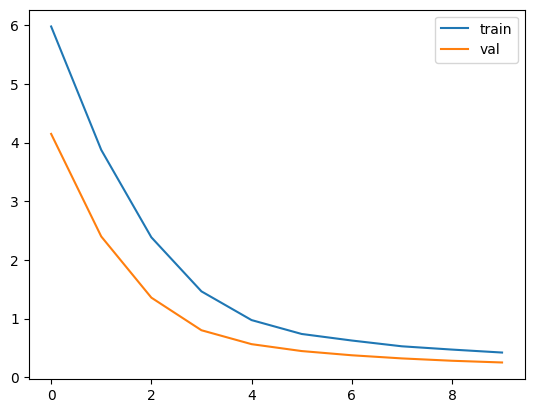

In [74]:
#plot the train and validation losses

plot_losses(train_loss_lst_2, val_loss_lst_2)

In [75]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

accuracy_fully_finetuned = test(test_loader_subset2, "Testing_subset2", net, {i: 0 for i in range(5, 10)})

Testing_subset2: 100%|██████████| 38/38 [00:00<00:00, 133.58it/s]

Accuracy: 0.921
Wrong counts for the digit 5: 86
Wrong counts for the digit 6: 40
Wrong counts for the digit 7: 92
Wrong counts for the digit 8: 98
Wrong counts for the digit 9: 69


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [132]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank, init="Normal"):
        super(ModifiedClassifier, self).__init__()
        
        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2, map_location=device))
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)
        
        # Define lora hyperparameters
        self.rank = lora_rank
        self.std = 1.0
        self.alpha = 1.0
        initialisations = ["Normal", "Xavier", "KaimingU"]
        assert init in initialisations, f"init should be one of {initialisations}"
        
        # Define lora weights matrices for each layer in pretrained model
        self.l1_lora_A = nn.Parameter(torch.empty(28*28, self.rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.rank, 1000))

        self.l2_lora_A = nn.Parameter(torch.empty(1000, self.rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.rank, 2000))

        self.l3_lora_A = nn.Parameter(torch.empty(2000, self.rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.rank, 5))
        
        # Initialization for lora layers
        if init == "Normal": 
            nn.init.normal_(self.l1_lora_A, std=self.std)
            nn.init.normal_(self.l2_lora_A, std=self.std)
            nn.init.normal_(self.l3_lora_A, std=self.std)
        
        if init == "Xavier":
            nn.init.xavier_normal_(self.l1_lora_A)
            nn.init.xavier_normal_(self.l2_lora_A)
            nn.init.xavier_normal_(self.l3_lora_A)

        if init == "KaimingU":
            nn.init.kaiming_uniform_(self.l1_lora_A)
            nn.init.kaiming_uniform_(self.l2_lora_A)
            nn.init.kaiming_uniform_(self.l3_lora_A)
        
        nn.init.zeros_(self.l1_lora_B)
        nn.init.zeros_(self.l2_lora_B)
        nn.init.zeros_(self.l3_lora_B)
       
        # freeze non lora weights
        for param in self.pretrained_net.parameters():
            param.requires_grad = False
                
    def lora_linear(self, x, layer, lora_A, lora_B):
        #Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        h = layer(x) + x @ (lora_A @ lora_B) * self.alpha
        return h
                     
        
    def forward(self, input):
        x = input.view(-1, 28*28)
        
        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #complete the remaining code (layer 2 and 3)
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B)
        
        return x

lora_rank=1
# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank, init="KaimingU").to(device)


Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [133]:
# Count the parameters introduced by lora layers
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters in the modified model: {count_parameters(modified_net):,}')

Total number of parameters in the modified model: 6,789


# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [134]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
train_loss_lst_lora1, val_loss_lst_lora1 = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

Training: 100%|██████████| 161/161 [00:03<00:00, 51.43it/s, loss=7.12]


Epoch [1/10] Train Loss: 7.120201128610173


Validation: 100%|██████████| 69/69 [00:00<00:00, 88.00it/s, loss=6.16]


Epoch [1/10] Validation Loss: 6.162601097770359


Training: 100%|██████████| 161/161 [00:03<00:00, 52.44it/s, loss=6.86]


Epoch [2/10] Train Loss: 6.859162970359281


Validation: 100%|██████████| 69/69 [00:00<00:00, 88.83it/s, loss=5.97]


Epoch [2/10] Validation Loss: 5.970879402713499


Training: 100%|██████████| 161/161 [00:03<00:00, 52.77it/s, loss=6.73]


Epoch [3/10] Train Loss: 6.732442340495424


Validation: 100%|██████████| 69/69 [00:00<00:00, 86.26it/s, loss=5.77]


Epoch [3/10] Validation Loss: 5.765553401864094


Training: 100%|██████████| 161/161 [00:03<00:00, 52.49it/s, loss=6.52]


Epoch [4/10] Train Loss: 6.522993149964706


Validation: 100%|██████████| 69/69 [00:00<00:00, 88.07it/s, loss=5.55]


Epoch [4/10] Validation Loss: 5.548901599386464


Training: 100%|██████████| 161/161 [00:03<00:00, 52.38it/s, loss=6.31]


Epoch [5/10] Train Loss: 6.308581989004005


Validation: 100%|██████████| 69/69 [00:00<00:00, 87.27it/s, loss=5.32]


Epoch [5/10] Validation Loss: 5.321629116500634


Training: 100%|██████████| 161/161 [00:03<00:00, 50.93it/s, loss=6.09]


Epoch [6/10] Train Loss: 6.091101516107595


Validation: 100%|██████████| 69/69 [00:00<00:00, 83.12it/s, loss=5.11]


Epoch [6/10] Validation Loss: 5.105785148731177


Training: 100%|██████████| 161/161 [00:03<00:00, 50.98it/s, loss=5.9] 


Epoch [7/10] Train Loss: 5.8994433687340395


Validation: 100%|██████████| 69/69 [00:00<00:00, 84.33it/s, loss=4.93]


Epoch [7/10] Validation Loss: 4.925568459690481


Training: 100%|██████████| 161/161 [00:03<00:00, 52.72it/s, loss=5.72]


Epoch [8/10] Train Loss: 5.724790953701327


Validation: 100%|██████████| 69/69 [00:00<00:00, 88.07it/s, loss=4.78]


Epoch [8/10] Validation Loss: 4.781222046285436


Training: 100%|██████████| 161/161 [00:03<00:00, 52.19it/s, loss=5.69]


Epoch [9/10] Train Loss: 5.685508257113629


Validation: 100%|██████████| 69/69 [00:00<00:00, 87.20it/s, loss=4.66]


Epoch [9/10] Validation Loss: 4.657964661501456


Training: 100%|██████████| 161/161 [00:03<00:00, 52.80it/s, loss=5.52]


Epoch [10/10] Train Loss: 5.523426334310022


Validation: 100%|██████████| 69/69 [00:00<00:00, 87.23it/s, loss=4.54]

Epoch [10/10] Validation Loss: 4.537197233974069


In [135]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"

for a, b in zip(original_weights, modified_net.pretrained_net.named_parameters()):
    print(f'{a} : {torch.equal(original_weights[a], b[1])}')

linear1.weight : True
linear1.bias : True
linear2.weight : True
linear2.bias : True
linear3.weight : True
linear3.bias : True


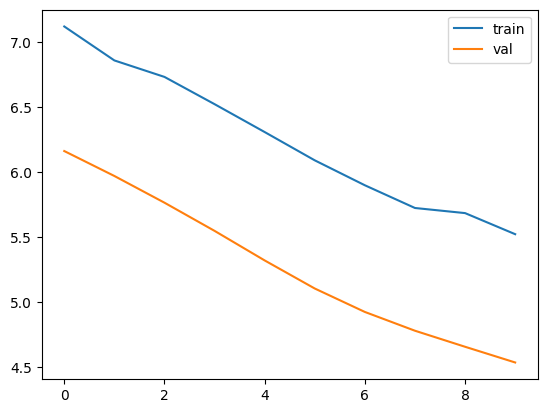

In [136]:
#plot losses

plot_losses(train_loss_lst_lora1, val_loss_lst_lora1)

In [137]:
#Compute test accuracy on MNIST 5...9 for that lora rank

accuracy_lora = test(test_loader_subset2, "Testing_subset2", modified_net, {i: 0 for i in range(5, 10)})

Testing_subset2: 100%|██████████| 38/38 [00:00<00:00, 90.36it/s]

Accuracy: 0.499
Wrong counts for the digit 5: 731
Wrong counts for the digit 6: 564
Wrong counts for the digit 7: 446
Wrong counts for the digit 8: 512
Wrong counts for the digit 9: 183


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added 

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9 

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

In [ ]:
lora_ranks = [1, 2, 4, 8, 16, 32, 64]
accuracies = []

for lora_rank in lora_ranks:
    modified_net = ModifiedClassifier(lora_rank, init="KaimingU").to(device)
    train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)
    accuracy = test(test_loader_subset2, "Testing_subset2", modified_net, {i: 0 for i in range(5, 10)})
    accuracies.append(accuracy)

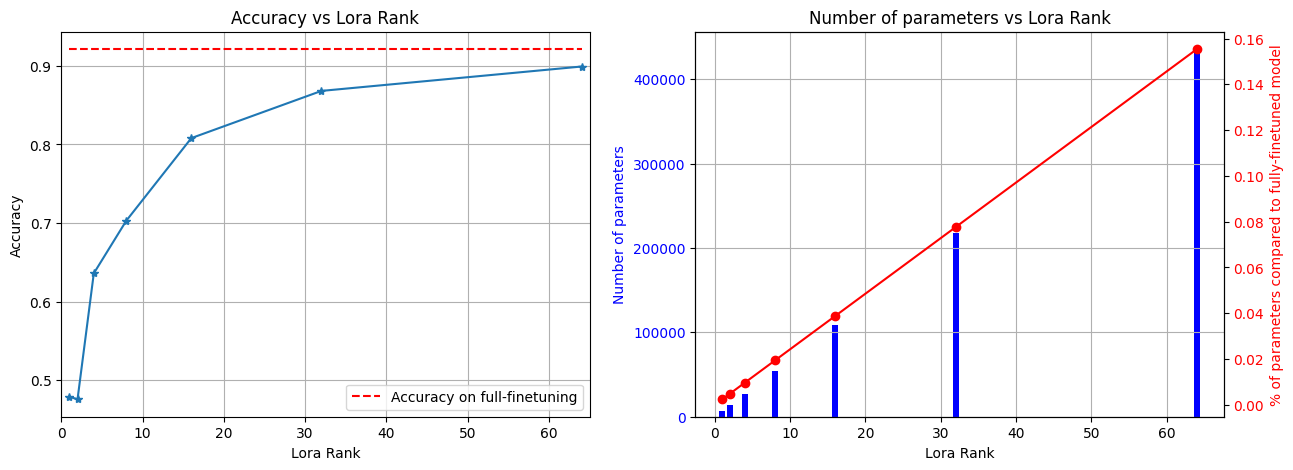

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(lora_ranks, accuracies, marker='*')
ax[0].hlines(y=accuracy_fully_finetuned, xmin=1, xmax=64, color='r', linestyle='--', label='Accuracy on full-finetuning')
ax[0].set_xlim(0, 65)
ax[0].set_xlabel('Lora Rank')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Lora Rank')
# Add grid
ax[0].grid()
ax[0].legend(loc = 'lower right')

ax[1].bar(lora_ranks, [count_parameters(ModifiedClassifier(rank, init="KaimingU")) for rank in lora_ranks], color='b')
# ax[1].hlines(y=count_parameters(net), xmin=1, xmax=64, color='r', linestyle='--', label='Fully finetuned')
ax[1].grid()
ax[1].set_xlabel('Lora Rank')
ax[1].set_ylabel('Number of parameters', color='b')
ax[1].tick_params(axis='y', labelcolor='b')
ax[1].set_title('Number of parameters vs Lora Rank')

ax2 = ax[1].twinx()
ax2.plot(lora_ranks, [count_parameters(ModifiedClassifier(rank, init="KaimingU"))/count_parameters(net) 
                      for rank in lora_ranks], color='r', marker='o')
ax2.set_ylabel('% of parameters compared to fully-finetuned model', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.show()
